In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam


In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


In [3]:
dataset = pd.read_csv("ai4i2020.csv")
dataset.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# Dataset description


Machine failure , TWF, HDF, PWF, OSF, RNF are the target variables. Ignore UDI and Product ID as they are not features 

The dataset consists of 10 000 data points stored as rows with 14 features in columns
UID: unique identifier ranging from 1 to 10000
product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail 





# Feature engineering

In [4]:
#Perform type mapping for "Type" column. Encode "Type" to numeric values
type_mapping = {'L':0, 'M':1, 'H':2}
dataset["Product quality"] = dataset["Type"].map(type_mapping)

features = dataset.drop(columns = ['UDI', 'Product ID', 'Type', 'Machine failure'])
labels = dataset["Machine failure"]

df = pd.concat([features, labels], axis = 1)

In [5]:
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Product quality,Machine failure
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,1,0
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0


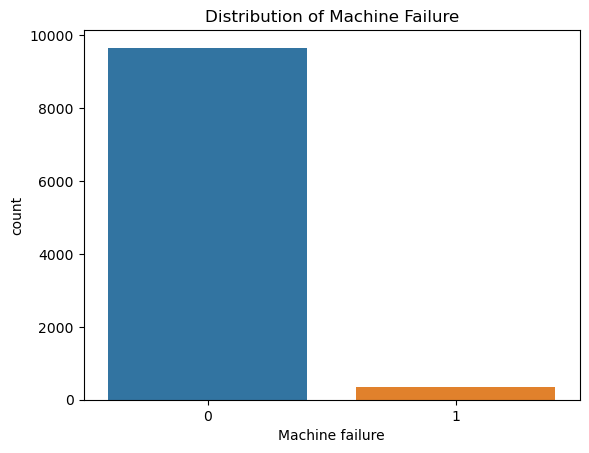

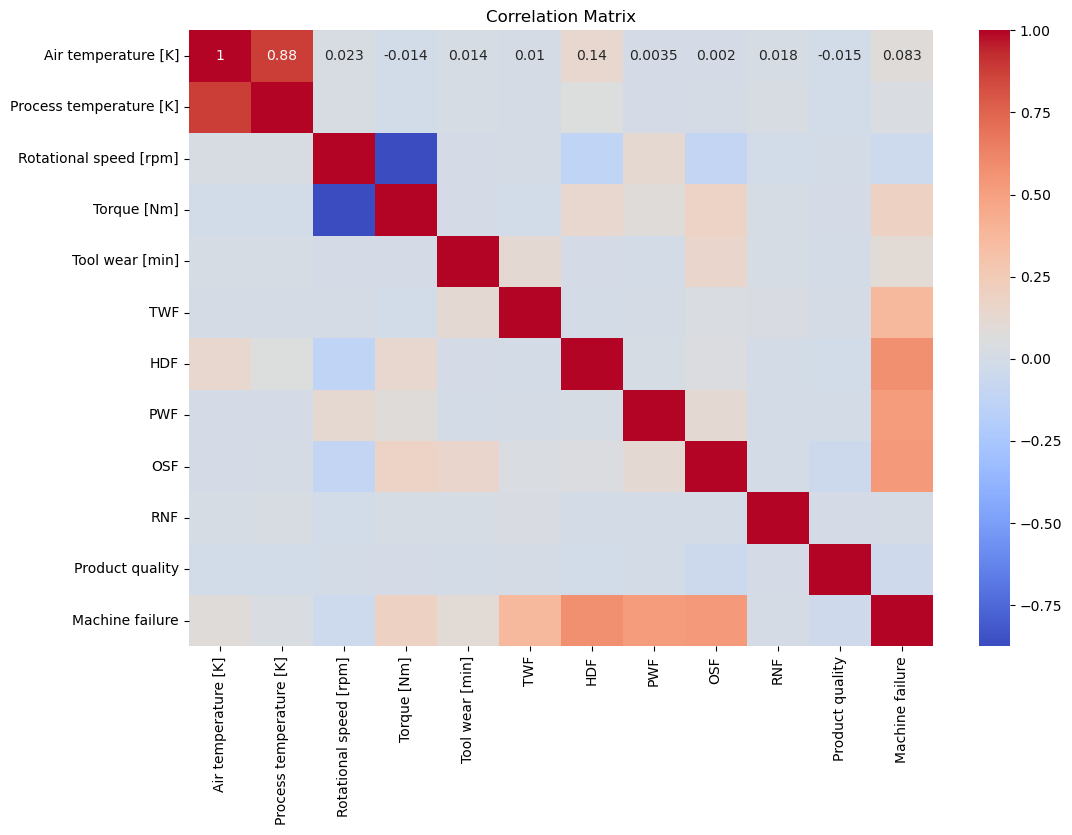

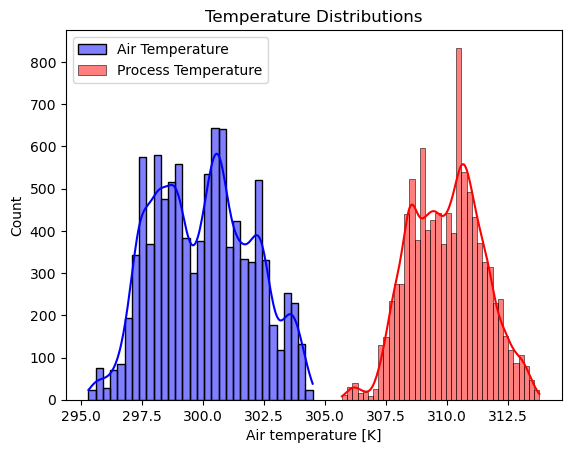

In [7]:
# Distribution of machine failure
sns.countplot(x='Machine failure', data=df)
plt.title('Distribution of Machine Failure')
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of air and process temperatures
sns.histplot(df['Air temperature [K]'], kde=True, color='blue', label='Air Temperature')
sns.histplot(df['Process temperature [K]'], kde=True, color='red', label='Process Temperature')
plt.title('Temperature Distributions')
plt.legend()
plt.show()

In [8]:
# Features for PCA
features = ['Air temperature [K]', 
            'Process temperature [K]', 
            'Rotational speed [rpm]', 
            'Torque [Nm]', 
            'Tool wear [min]', 
            'Product quality',
            'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Standardizing the features
x = df[features]
x = StandardScaler().fit_transform(x)

# PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(x)

# Creating a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Adding the target variable to the DataFrame
pca_df = pd.concat([pca_df, df[['Machine failure']]], axis=1)

# Display the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance ratio: {explained_variance}')


Explained variance ratio: [0.17824189 0.17269674]


In [10]:
pca_df.head()

,PC1,PC2,Machine failure
0,-0.122776,-1.408283,0
1,-0.912814,-1.270385,0
2,-0.797707,-1.397253,0
3,-0.359878,-1.331589,0
4,-0.485258,-1.281250,0


In [15]:
# Split data into training and testing sets
X = pca_df.drop(['Machine failure'], axis = 1)
y = pca_df['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Isolation forest

In [16]:
iso_forest = IsolationForest(random_state=42)

# Define the parameter grid
iso_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.6, 0.8, 1.0],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [1.0, 0.8, 0.6]
}

# Perform GridSearchCV
iso_grid = GridSearchCV(iso_forest, param_grid=iso_param_grid, scoring='accuracy', cv=5)
iso_grid.fit(X_train)

# Predict using the best estimator
iso_best = iso_grid.best_estimator_
iso_pred = iso_best.predict(X_test)
iso_pred = np.where(iso_pred == 1, 0, 1)  # Map 1 -> 0 (normal) and -1 -> 1 (anomaly)

# Print the best parameters
print(f"Best parameters for Isolation Forest: {iso_grid.best_params_}")


Best parameters for Isolation Forest: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 50}


# Density based spatial clustering

In [17]:
dbscan = DBSCAN()

# Define the parameter grid
dbscan_param_grid = {
    'eps': [0.3, 0.5, 0.7],
    'min_samples': [5, 10, 15]
}

# Perform GridSearchCV (RandomizedSearchCV for larger search space)
dbscan_grid = GridSearchCV(dbscan, param_grid=dbscan_param_grid, scoring='accuracy', cv=5)
dbscan_grid.fit(X_test)  # Fit directly on X_test due to how DBSCAN works

# Predict using the best estimator
dbscan_best = dbscan_grid.best_estimator_
dbscan_pred = dbscan_best.fit_predict(X_test)
dbscan_pred = np.where(dbscan_pred == -1, 1, 0)  # Mark -1 as anomalies

# Print the best parameters
print(f"Best parameters for DBSCAN: {dbscan_grid.best_params_}")


Best parameters for DBSCAN: {'eps': 0.3, 'min_samples': 5}


# One Class SVM

In [20]:
oc_svm = OneClassSVM()

# Define the parameter grid
svm_param_grid = {
    'nu': [0.01, 0.05, 0.1],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform GridSearchCV
svm_grid = GridSearchCV(oc_svm, param_grid=svm_param_grid, scoring='accuracy', cv=5)
svm_grid.fit(X_train)

# Predict using the best estimator
oc_svm_best = svm_grid.best_estimator_
oc_svm_pred = oc_svm_best.predict(X_test)
oc_svm_pred = np.where(oc_svm_pred == 1, 0, 1)  # Convert to 0 for normal, 1 for anomaly

# Print the best parameters
print(f"Best parameters for One-Class SVM: {svm_grid.best_params_}")


Best parameters for One-Class SVM: {'gamma': 'scale', 'kernel': 'linear', 'nu': 0.01}


# Local Outlier Factor

In [23]:
lof = LocalOutlierFactor()

# Define the parameter grid
lof_param_grid = {
    'n_neighbors': [10, 20, 30],
    'contamination': [0.01, 0.05, 0.1]
}

# Perform GridSearchCV
lof_grid = GridSearchCV(lof, param_grid=lof_param_grid, scoring='accuracy', cv=5)
lof_grid.fit(X_test)  # Fit directly on X_test due to how LOF works

# Predict using the best estimator
lof_best = lof_grid.best_estimator_
lof_pred = lof_best.fit_predict(X_test)
lof_pred = np.where(lof_pred == 1, 0, 1)  # Convert to 0 for normal, 1 for anomaly

# Print the best parameters
print(f"Best parameters for Local Outlier Factor: {lof_grid.best_params_}")


Best parameters for Local Outlier Factor: {'contamination': 0.01, 'n_neighbors': 10}


# Evaluation Metric

In [24]:
print("Isolation Forest Classification Report")
print(classification_report(y_test, iso_pred))

print("\nDBSCAN Classification Report")
print(classification_report(y_test, dbscan_pred))

print("\nOne-Class SVM Classification Report")
print(classification_report(y_test, oc_svm_pred))

print("\nLocal Outlier Factor Classification Report")
print(classification_report(y_test, lof_pred))


Isolation Forest Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2907
           1       0.77      0.22      0.34        93

    accuracy                           0.97      3000
   macro avg       0.87      0.61      0.66      3000
weighted avg       0.97      0.97      0.97      3000


DBSCAN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2907
           1       0.47      0.66      0.55        93

    accuracy                           0.97      3000
   macro avg       0.73      0.82      0.76      3000
weighted avg       0.97      0.97      0.97      3000


One-Class SVM Classification Report
              precision    recall  f1-score   support

           0       0.97      0.46      0.62      2907
           1       0.03      0.59      0.06        93

    accuracy                           0.46      3000
   macro avg       0.5

# Random Forest Classifier

In [25]:
# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2903    4]
 [  30   63]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2907
           1       0.94      0.68      0.79        93

    accuracy                           0.99      3000
   macro avg       0.97      0.84      0.89      3000
weighted avg       0.99      0.99      0.99      3000



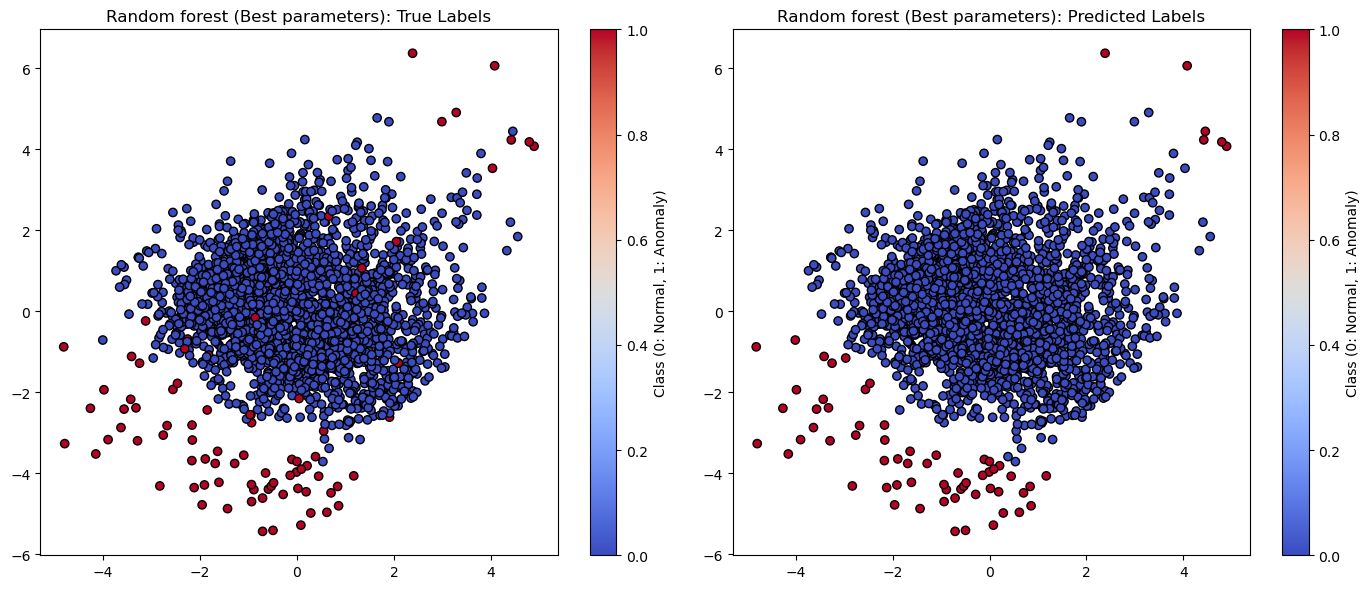

In [26]:
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
X_test_2D = pca.fit_transform(X_test_array)

# Plot function for visualization
def plot_comparison(X, true_labels, pred_labels, title):
    plt.figure(figsize=(14, 6))

    # Subplot 1: True Labels
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='coolwarm', marker='o', edgecolor='k')
    plt.title(f"{title}: True Labels")
    plt.colorbar(label='Class (0: Normal, 1: Anomaly)')
    
    # Subplot 2: Predicted Labels
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=pred_labels, cmap='coolwarm', marker='o', edgecolor='k')
    plt.title(f"{title}: Predicted Labels")
    plt.colorbar(label='Class (0: Normal, 1: Anomaly)')

    plt.tight_layout()
    plt.show()

# Assuming y_test contains the ground truth labels (0 for normal, 1 for anomaly)
plot_comparison(X_test_2D, y_test, y_pred, "Random forest (Best parameters)")


# Autoencoders

Epoch 1/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.2652 - val_loss: 1.0030
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9348 - val_loss: 0.8378
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7447 - val_loss: 0.7696
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7491 - val_loss: 0.7369
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7106 - val_loss: 0.7197
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7592 - val_loss: 0.7111
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6842 - val_loss: 0.7060
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7517 - val_loss: 0.7029
Epoch 9/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7414 - val_loss: 0.7009
Epoch 10/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6585 - val_loss: 0.6992
Epoch 11/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6999 - val_loss: 0.6980
Epoch 12/500
200/200 ━━━━━━━━━━━━━━━━━━━━

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6788 - val_loss: 0.6850
Epoch 69/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6878 - val_loss: 0.6850
Epoch 70/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6747 - val_loss: 0.6850
Epoch 71/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7123 - val_loss: 0.6850
Epoch 72/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6215 - val_loss: 0.6850
Epoch 73/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6510 - val_loss: 0.6850
Epoch 74/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7148 - val_loss: 0.6850
Epoch 75/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6910 - val_loss: 0.6850
Epoch 76/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7185 - val_loss: 0.6849
Epoch 77/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7317 - val_loss: 0.6849
Epoch 78/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6762 - val_loss: 0.6849
Epoch 79/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7187 - val_loss: 0.6846
Epoch 136/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7271 - val_loss: 0.6846
Epoch 137/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7315 - val_loss: 0.6846
Epoch 138/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6546 - val_loss: 0.6846
Epoch 139/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6581 - val_loss: 0.6846
Epoch 140/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5994 - val_loss: 0.6846
Epoch 141/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6573 - val_loss: 0.6846
Epoch 142/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7162 - val_loss: 0.6846
Epoch 143/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7054 - val_loss: 0.6846
Epoch 144/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6818 - val_loss: 0.6846
Epoch 145/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6562 - val_loss: 0.6846
Epoch 146/500
200/200

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6712 - val_loss: 0.6824
Epoch 202/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6919 - val_loss: 0.6824
Epoch 203/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7180 - val_loss: 0.6824
Epoch 204/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7457 - val_loss: 0.6824
Epoch 205/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6478 - val_loss: 0.6824
Epoch 206/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7347 - val_loss: 0.6824
Epoch 207/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7315 - val_loss: 0.6824
Epoch 208/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6451 - val_loss: 0.6824
Epoch 209/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6916 - val_loss: 0.6824
Epoch 210/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6990 - val_loss: 0.6824
Epoch 211/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6838 - val_loss: 0.6824
Epoch 212/500
200/200 ━━━━━━━━━━━━━

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6456 - val_loss: 0.6823
Epoch 268/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6713 - val_loss: 0.6823
Epoch 269/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6391 - val_loss: 0.6823
Epoch 270/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6817 - val_loss: 0.6823
Epoch 271/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6902 - val_loss: 0.6823
Epoch 272/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7532 - val_loss: 0.6823
Epoch 273/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6673 - val_loss: 0.6823
Epoch 274/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7371 - val_loss: 0.6823
Epoch 275/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6364 - val_loss: 0.6823
Epoch 276/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6829 - val_loss: 0.6823
Epoch 277/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7143 - val_loss: 0.6823
Epoch 278/500
200/200 ━━━━━━━━━━━━━

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6801 - val_loss: 0.6823
Epoch 334/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7491 - val_loss: 0.6823
Epoch 335/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7150 - val_loss: 0.6823
Epoch 336/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7149 - val_loss: 0.6823
Epoch 337/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7061 - val_loss: 0.6823
Epoch 338/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6874 - val_loss: 0.6823
Epoch 339/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6809 - val_loss: 0.6823
Epoch 340/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7526 - val_loss: 0.6823
Epoch 341/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6968 - val_loss: 0.6823
Epoch 342/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6566 - val_loss: 0.6823
Epoch 343/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6776 - val_loss: 0.6823
Epoch 344/500
200/200 ━━━━━━━━━━━━━

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6979 - val_loss: 0.6823
Epoch 400/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6683 - val_loss: 0.6823
Epoch 401/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6922 - val_loss: 0.6823
Epoch 402/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6671 - val_loss: 0.6823
Epoch 403/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7543 - val_loss: 0.6823
Epoch 404/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6621 - val_loss: 0.6823
Epoch 405/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7090 - val_loss: 0.6823
Epoch 406/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7324 - val_loss: 0.6823
Epoch 407/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7170 - val_loss: 0.6823
Epoch 408/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7287 - val_loss: 0.6823
Epoch 409/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7731 - val_loss: 0.6823
Epoch 410/500
200/200 ━━━━━━━━━━━━━

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6829 - val_loss: 0.6823
Epoch 466/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7090 - val_loss: 0.6823
Epoch 467/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6827 - val_loss: 0.6823
Epoch 468/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7093 - val_loss: 0.6823
Epoch 469/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7390 - val_loss: 0.6823
Epoch 470/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7589 - val_loss: 0.6823
Epoch 471/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6700 - val_loss: 0.6823
Epoch 472/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5995 - val_loss: 0.6823
Epoch 473/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6877 - val_loss: 0.6823
Epoch 474/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7508 - val_loss: 0.6823
Epoch 475/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6912 - val_loss: 0.6823
Epoch 476/500
200/200 ━━━━━━━━━━━━━

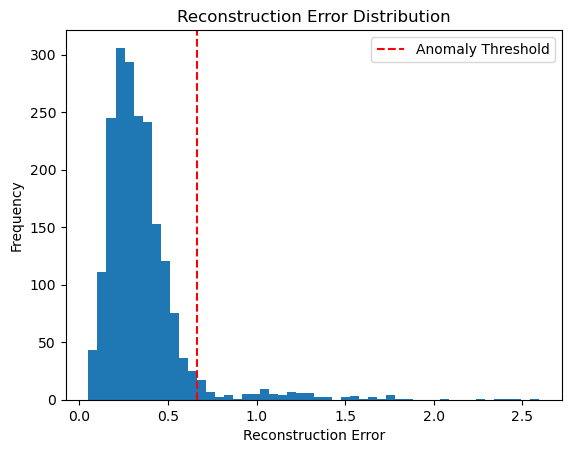

              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99      1932
     Anomaly       0.66      0.97      0.79        68

    accuracy                           0.98      2000
   macro avg       0.83      0.98      0.89      2000
weighted avg       0.99      0.98      0.98      2000

Accuracy: 98.20%
Precision: 66.00%
Recall: 97.06%
F1 Score: 78.57%
Anomalies found at indices: [   3    9   14   17   21   40   43   64   65   66   97   98  121  127
  144  159  222  316  342  346  350  370  388  483  502  503  524  549
  552  562  590  605  644  645  666  674  692  776  779  782  793  801
  828  856  877  886  919  920  931  963  969 1045 1065 1085 1088 1154
 1178 1180 1189 1225 1228 1258 1271 1291 1293 1322 1350 1364 1367 1414
 1434 1438 1445 1481 1500 1505 1515 1517 1539 1563 1598 1617 1636 1673
 1688 1722 1745 1749 1774 1846 1855 1862 1866 1910 1920 1930 1949 1956
 1963 1971]
Reconstruction errors of anomalies: [0.70201152 0.95374258 0.67311918

In [42]:
x = df[features].values
y = dataset['Machine failure'].values  # Assuming your true labels are in this column

# Split data into training (normal) and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the autoencoder model
input_dim = X_train_scaled.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")

# Train the autoencoder
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=500,
                          batch_size=32,
                          validation_split=0.2,
                          shuffle=True)

# Predict and calculate reconstruction error
X_test_reconstructed = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.abs(X_test_scaled - X_test_reconstructed), axis=1)

# Set anomaly detection threshold
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold

# Visualize reconstruction error distribution
plt.hist(reconstruction_error, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Evaluate model performance
y_pred = anomalies.astype(int)  # Convert boolean predictions to integers

# Print classification report
print(classification_report(y_test, y_pred, target_names=["Normal", "Anomaly"]))

# Additional metrics
TP = np.sum((y_test == 1) & (y_pred == 1))  # True Positives
TN = np.sum((y_test == 0) & (y_pred == 0))  # True Negatives
FP = np.sum((y_test == 0) & (y_pred == 1))  # False Positives
FN = np.sum((y_test == 1) & (y_pred == 0))  # False Negatives

# Calculate additional metrics
accuracy = (TP + TN) / len(y_test)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")

# Get anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Anomalies found at indices: {anomaly_indices}")
print(f"Reconstruction errors of anomalies: {reconstruction_error[anomaly_indices]}")


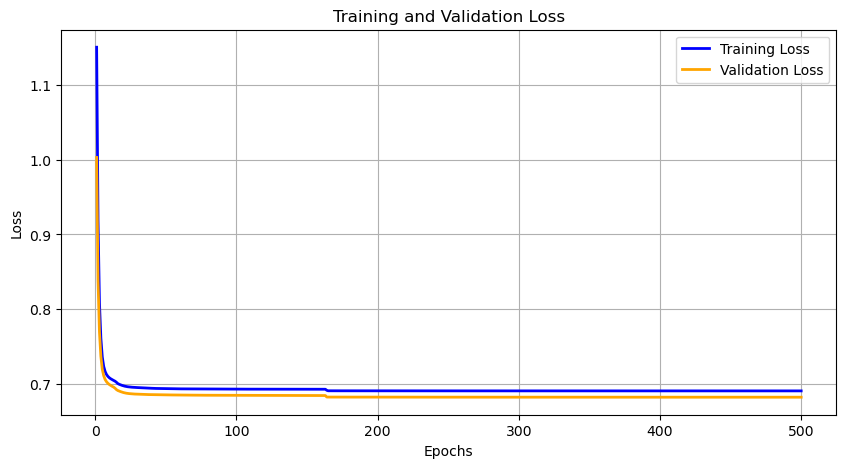

In [43]:
# Extracting loss and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Create a plot for loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', color='orange', linewidth=2)

# Adding titles and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plot
plt.show()
